# Computationally Efficient Stain Agnostic Nuclei Segmentation

##### $\textit{Zacharie Fredj-Zadoun (zacharie.fredj-zadoun@student-cs.fr) - Maria Kontaratou (maria.kontaratou@student-cs.fr)}$

This notebook presents **ChannelNet_CellViT**, a hybrid deep learning architecture designed to perform **stain-agnostic, high-resolution nuclei segmentation** across diverse microscopy datasets.

Models like CellViT are typically built for 3-channel (RGB-style) inputs, while ChannelInvariantNet is designed to handle high-dimensional multiplexed data but outputs a fixed 3-channel representation. This allows compatibility with standard segmentation architectures but requires careful adaptation when working directly with 32-channel input tensors.

To address this, we introduce a lightweight **ChannelAdapter** module:
- Projects 32-channel inputs to 3-channel tensors
- Applies **residual connections** and **batch normalization** for stability
- Preserves compatibility with pre-trained or 3-channel-specific architectures

The final model, **ChannelNet_CellViT**, combines:
- A **ChannelInvariantNet** to extract stain-invariant spatial features
- A modified **CellViT Transformer** to learn global context and boundary precision
- Our custom **ChannelAdapter** to bridge the channel gap

We apply this architecture to CPDMI (Vectra + Zeiss) and CODEX datasets, demonstrating strong generalization through custom loss functions and instance-level metrics.

> This notebook walks through the full pipeline: preprocessing, architecture, training, evaluation, and visualization.

<a id="0"></a>  
## Table of Contents

1. [Imports](#1)  
2. [Model Architecture](#2)  
3. [Training](#3)  
    3.1. [CPDMI Training Datasets: Vectra & Zeiss](#31)  
    3.2. [Percentile-Based Normalization for CPDMI](#32)  
    3.3. [Training & Validation Setup](#33)  
    3.4. [Loss Function: Lovász-Hinge + Cross Entropy](#34)  
    3.5. [Training Strategy & Monitoring](#35)  
    3.6. [Load the Best Model & Visualize ](#36)  
4. [Testing & Evaluation](#4)  
    4.1. [Dataset Testing Loader and Preprocessing](#41)  
    4.2. [Model Evaluation on Test Set](#42)  


<a id="1"></a>  
## 1. Imports


In [ ]:
import os
import sys
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import softmax
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torch.cuda.amp import GradScaler, autocast
import torchvision.transforms as transforms
from torchvision import transforms as T
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from stardist import matching
from skimage.measure import label
from skimage.morphology import remove_small_objects, remove_small_holes
from sklearn.metrics import (
    f1_score, precision_score, recall_score, average_precision_score
)


# Set the base directory to the repository root
base_path = '/usr/users/nucleisegmentation/kontaratou_mar/CellViT-plus-plus'
if base_path not in sys.path:
    sys.path.append(base_path)

try:
    from cellvit.models.cell_segmentation.cellvit import CellViT
    print("CellViT successfully imported!")
except ModuleNotFoundError as e:
    print(f"Error importing CellViT: {e}")

channel_invariant_net_path = '/usr/users/nucleisegmentation/kontaratou_mar/instanseg/instanseg/utils/models'
if channel_invariant_net_path not in sys.path:
    sys.path.append(channel_invariant_net_path)

try:
    from ChannelInvariantNet import ChannelInvariantNet
    print("ChannelInvariantNet successfully imported!")
except ModuleNotFoundError as e:
    print(f"Error importing ChannelInvariantNet: {e}")


CellViT successfully imported!
ChannelInvariantNet successfully imported!



<a id="2"></a>  
## 2. Model Architecture


### ChannelAdapter + ChannelNet_CellViT

To handle our 32-channel input data, we introduce the `ChannelAdapter` — a lightweight convolutional block that compresses the input to 3 channels using:

- Two 3×3 convolutional layers with BatchNorm and ReLU
- A 1×1 output convolution
- Optional residual connection for stability

This enables compatibility with both:
- **ChannelInvariantNet**: for stain-invariant feature extraction
- **CellViT**: for transformer-based segmentation

We integrate all three components into a unified `ChannelNet_CellViT` model. Configuration settings adjust both sub-models to handle 3-channel input and maintain architectural balance.


In [ ]:
class ChannelAdapter(nn.Module):
    def __init__(self, in_channels=32, out_channels=3):
        super().__init__()
        mid_channels = 32
        self.conv1 = nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(mid_channels)
        self.conv2 = nn.Conv2d(mid_channels, mid_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(mid_channels)
        self.conv_out = nn.Conv2d(mid_channels, out_channels, kernel_size=1)
        self.has_residual = (in_channels == out_channels)

    def forward(self, x):
        identity = x
        x = F.relu(self.bn1(self.conv1(x)))
        res = x
        x = F.relu(self.bn2(self.conv2(x)) + res)
        x = self.conv_out(x)

        if self.has_residual:
            x = x + identity

        return x  


class ChannelNet_CellViT(nn.Module):
    def __init__(self, channel_invariant_config, cellvit_config):
        super(ChannelNet_CellViT, self).__init__()
        
        # Adapter: convert 32-channel input from dataset to 3 channels for ChannelInvariantNet
        self.adapter_pre = ChannelAdapter(in_channels=32, out_channels=3)
    
        self.channel_invariant_net = ChannelInvariantNet(**channel_invariant_config)
        self.cellvit = CellViT(**cellvit_config)

    def forward(self, x):
        # Convert the 32-channel input to 3 channels
        x_adapted = self.adapter_pre(x)
        
        channel_invariant_output = self.channel_invariant_net(x_adapted)
        cellvit_output = self.cellvit(channel_invariant_output)
        
        return cellvit_output


channel_invariant_config = {
    # Keep the original configuration as in the paper
    "out_channels": 3,
    "layers": [64, 32, 16],
    "act": "ReLU",
    "norm": "BATCH",
    "aggregation": "sum",
}

# Update CellViT to expect 3-channel input
cellvit_config = {
    "input_channels": 3,  # Changed from 32 to 3
    "num_nuclei_classes": 2,
    "num_tissue_classes": 1,
    "embed_dim": 128,  
    "depth": 8,       
    "num_heads": 8,   
    "extract_layers": [1, 3, 5, 6],
    "mlp_ratio": 4,
    "qkv_bias": True,
    "drop_rate": 0.1,
    "attn_drop_rate": 0.1,
    "drop_path_rate": 0.1,
    "regression_loss": False,
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ChannelNet_CellViT(
    channel_invariant_config=channel_invariant_config,
    cellvit_config=cellvit_config,
).to(device)


<a id="3"></a>  
## 3. Training

<a id="31"></a>  
### 3.1 CPDMI Training Datasets: Vectra & Zeiss


We define two dataset classes to load and prepare microscopy data:

- **CPDMIAggregatedDataset (Vectra)**  
  Merges DAPI and Cell channel images → `[2, H, W]`, then replicated to `[32, H, W]` 

- **ZeissDataset**  
  Uses Cell channel only, duplicated → `[2, H, W]`, then replicated to `[32, H, W]`



In [ ]:
class CPDMIAggregatedDataset(Dataset):
    def __init__(self, root_dir, dapi_channel="Dapi", transform=None, max_channels=32):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.max_channels = max_channels
        self.image_mask_pairs = []

        # Collect DAPI and cytoplasmic/membranous image-mask pairs
        for p_dir in self.root_dir.glob("P*"):  # P01, P02, ...
            for sub_dir in p_dir.glob("*"):  # Subfolders
                dapi_image_path = sub_dir / f"{sub_dir.name}-Crop_{dapi_channel}_Png.png"
                cell_image_path = sub_dir / f"{sub_dir.name}-Crop_Cell_Png.png"
                mask_path = sub_dir / f"{sub_dir.name}-Crop_Dapi_Mask_Png.png"

                if dapi_image_path.exists() and cell_image_path.exists() and mask_path.exists():
                    self.image_mask_pairs.append((dapi_image_path, cell_image_path, mask_path))

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        dapi_image_path, cell_image_path, mask_path = self.image_mask_pairs[idx]

        dapi_image = Image.open(dapi_image_path).convert("L")
        cell_image = Image.open(cell_image_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            dapi_image = self.transform(dapi_image).squeeze(0)  # Remove extra channel dimension
            cell_image = self.transform(cell_image).squeeze(0)
            mask = self.transform(mask)

        # Merge DAPI and Cell images into one tensor
        merged_image = torch.stack([dapi_image, cell_image], dim=0)  # Shape: [2, H, W]

        # Instead of padding with zeros, replicate the two channels to reach max_channels.
        replication_factor = self.max_channels // merged_image.size(0)  # For 32 channels, factor is 16.
        replicated_image = merged_image.repeat(replication_factor, 1, 1)  # Shape: [32, H, W]


        return replicated_image, mask



class ZeissDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_channels=32):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.max_channels = max_channels
        self.image_mask_pairs = []

        for sub_dir in self.root_dir.glob("*"):
            cell_image_path = sub_dir / f"{sub_dir.name}-Crop_Cell_Png.png"
            mask_path = sub_dir / f"{sub_dir.name}-Crop_Cell_Mask_Png.png"
            if cell_image_path.exists() and mask_path.exists():
                self.image_mask_pairs.append((cell_image_path, mask_path))

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        cell_image_path, mask_path = self.image_mask_pairs[idx]

        # Open images and mask
        cell_image = Image.open(cell_image_path).convert("L")
        mask = Image.open(mask_path).convert("L")

        # Apply transformations
        if self.transform:
            cell_image = self.transform(cell_image).squeeze(0)  # Remove the channel dimension
            mask = self.transform(mask)  # Mask remains [1, H, W]

        # We have only one channel from 'cell_image', but for consistency, stack it twice.
        # This gives us 2 channels: [cell, cell].
        merged_image = torch.stack([cell_image, cell_image], dim=0)  # [2, H, W]

        # Instead of padding with zeros, replicate these 2 channels to get 32.
        replication_factor = self.max_channels // merged_image.size(0)  # e.g., 32 // 2 = 16
        replicated_image = merged_image.repeat(replication_factor, 1, 1)  # [32, H, W]

        return replicated_image, mask



# Define root directories
vectra_root_dir = "/usr/users/nucleisegmentation/kontaratou_mar/ChannelNet+CellViT/CPDMI_2023/Vectra"
zeiss_root_dir = "/usr/users/nucleisegmentation/kontaratou_mar/ChannelNet+CellViT/CPDMI_2023/Zeiss"

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BICUBIC),  
    transforms.ToTensor(),  
])


# Load datasets
vectra_dataset = CPDMIAggregatedDataset(root_dir=vectra_root_dir, transform=transform)
zeiss_dataset = ZeissDataset(root_dir=zeiss_root_dir, transform=transform)

# Combine datasets
combined_dataset = ConcatDataset([vectra_dataset, zeiss_dataset])
print(f"Total number of samples in combined dataset: {len(combined_dataset)}")

# Define DataLoader
data_loader = DataLoader(combined_dataset, batch_size=3, shuffle=True)

# Test the DataLoader
for batch_images, batch_masks in data_loader:
    print(f"Batch images shape: {batch_images.shape}")  
    print(f"Batch masks shape: {batch_masks.shape}")    
    break


Total number of samples in combined dataset: 65
Batch images shape: torch.Size([3, 32, 256, 256])
Batch masks shape: torch.Size([3, 1, 256, 256])


<a id="32"></a>  
### 3.2 Percentile-Based Normalization for CPDMI

To reduce staining and illumination variability, we apply a custom **percentile scaling** transform:

- Rescales pixel values based on the 0.1 and 99.9 percentiles  
- Enhances contrast and normalizes intensity across images  
- Improves generalization across diverse staining conditions

This normalization is applied before resizing and tensor conversion. The same transform is used for both **Vectra** and **Zeiss** datasets

In [ ]:
class PercentileScaling:
    def __call__(self, image):
        image_np = np.array(image, dtype=np.float32)
        lower = np.percentile(image_np, 0.1)
        upper = np.percentile(image_np, 99.9)
        image_np = (image_np - lower) / (upper - lower)
        image_np = np.clip(image_np, 0, 1)
        return Image.fromarray((image_np * 255).astype(np.uint8))  

cpdmi_transform = transforms.Compose([
    PercentileScaling(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

vectra_dataset = CPDMIAggregatedDataset(root_dir=vectra_root_dir, transform=cpdmi_transform)
zeiss_dataset = ZeissDataset(root_dir=zeiss_root_dir, transform=cpdmi_transform)

combined_dataset = ConcatDataset([vectra_dataset, zeiss_dataset])
data_loader = DataLoader(combined_dataset, batch_size=3, shuffle=True)

<a id="33"></a>  
### 3.3 Training & Validation Setup

#### Data Split
- We randomly split the combined dataset into: **80% training**, **20% validation**
- A fixed seed ensures reproducibility

#### DataLoaders
- Batch size is set to **3**, as reported in the original paper
- Training loader is shuffled; validation is not

#### Training Loop (`train_one_epoch`)
- Uses **mixed precision** (via `autocast`) and **gradient accumulation** for memory efficiency
- Applies **gradient clipping** to stabilize training
- Returns average training loss

#### Validation Loop (`validate_one_epoch`)
- Computes validation loss and multiple metrics:
  - `F1@0.5`, `F1-mean` (across thresholds), and **Segmentation Quality (SQ)**
- Leverages **StarDist's instance-level matching** for metric calculation


In [ ]:
train_size = int(0.8 * len(combined_dataset))  # 80% for training
val_size = len(combined_dataset) - train_size  # Remaining 20% for validation
torch.manual_seed(42)  
train_dataset, val_dataset = random_split(combined_dataset, [train_size, val_size])

# Define DataLoaders
batch_size = 3  # From the paper
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)


def train_one_epoch(model, train_loader, criterion, optimizer, scaler, device, accumulation_steps=4):
    model.train()
    train_loss = 0

    for step, (batch_images, batch_masks) in enumerate(tqdm(train_loader, desc="Training", disable=True)):
        batch_images, batch_masks = batch_images.to(device), batch_masks.to(device)
        optimizer.zero_grad()

        # Forward pass with mixed precision
        with autocast():
            outputs = model(batch_images)
            nuclei_binary_map = outputs["nuclei_binary_map"]  # Adjust key based on model
            loss = criterion(nuclei_binary_map, batch_masks.squeeze(1).long()) / accumulation_steps

        # Backward pass
        scaler.scale(loss).backward()
        # Clip gradients to avoid exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        # Step optimizer after accumulation steps
        if (step + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps

    return train_loss / len(train_loader)

# Validation function
def validate_one_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0
    f1_at_0_5_scores, f1_mean_scores, sq_scores = [], [], []

    with torch.no_grad():
        for batch_images, batch_masks in tqdm(val_loader, desc="Validation", disable=True):
            batch_images, batch_masks = batch_images.to(device), batch_masks.to(device)

            # Forward pass with mixed precision
            with autocast():
                outputs = model(batch_images)
                nuclei_binary_map = outputs["nuclei_binary_map"]
                loss = criterion(nuclei_binary_map, batch_masks.squeeze(1).long())

            # Accumulate loss
            val_loss += loss.item()

            # Compute Metrics
            for pred, true in zip(nuclei_binary_map, batch_masks):
                pred_np = torch.argmax(pred, dim=0).cpu().numpy()  
                true_np = true.squeeze(0).cpu().numpy()  
                
                # Ensure true_np is a 2D array of integers
                true_np = true_np.astype(np.int32)

                # Stardist matching metrics
                results = matching.matching(true_np, pred_np, thresh=0.5)
                f1_at_0_5 = results.f1  # Directly access the `f1` attribute
                sq = results.mean_matched_score  # Use `mean_matched_score` for segmentation quality (SQ)

                # F1 mean over thresholds
                f1_mean = np.mean([
                    matching.matching(true_np, pred_np, thresh=t).f1
                    for t in [0.5, 0.6, 0.7, 0.8, 0.9]
                ])

                f1_at_0_5_scores.append(f1_at_0_5)
                f1_mean_scores.append(f1_mean)
                sq_scores.append(sq)

    avg_val_loss = val_loss / len(val_loader)
    avg_f1_at_0_5 = np.mean(f1_at_0_5_scores)
    avg_f1_mean = np.mean(f1_mean_scores)
    avg_sq = np.mean(sq_scores)


    return avg_val_loss, avg_f1_mean, avg_f1_at_0_5, avg_sq

<a id="34"></a>  
### 3.4 Loss Function: Lovász-Hinge + Cross Entropy

We define a custom **composite loss** to guide the segmentation model. It combines **region-aware** and **boundary-aware** objectives:

#### Lovász-Hinge Loss

- Optimizes the **Jaccard index (IoU)** directly:
  
  $$
  \text{IoU}(A, B) = \frac{|A \cap B|}{|A \cup B|}
  $$

- Works on the **foreground class logits** using hinge loss formulation:
  
  $$
  \mathcal{L}_{\text{Lovasz}} = \sum_{i=1}^{p} \Delta_i \cdot \max(0, 1 - y_i f_i)
  $$

  where $ \Delta_i $ is the gradient of IoU, $ y_i \in \{-1, +1\} $, and $ f_i $ is the logit score



#### Weighted Cross Entropy Loss

- Standard classification loss for multi-class segmentation:

  $$
  \mathcal{L}_{\text{CE}} = - \sum_{c=1}^{C} w_c \cdot y_c \cdot \log(\hat{y}_c)
  $$

  where:
  - $C $: number of classes
  - $ y_c $: ground truth label
  - $ \hat{y}_c $: predicted probability
  - $ w_c $: optional class weight

####  Final Combined Loss

- We blend both losses to guide the model toward **accurate regions and precise boundaries**:

  $$
  \mathcal{L}_{\text{total}} = \lambda \cdot \mathcal{L}_{\text{Lovasz}} + (1 - \lambda) \cdot \mathcal{L}_{\text{CE}}
  $$

  - In our case: $ \lambda = 0.7 $


In [ ]:
# Lovász Hinge loss implementation
# Credit: https://github.com/bermanmaxim/LovaszSoftmax (simplified here)

def lovasz_grad(gt_sorted):
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: 
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge_flat(logits, labels):
    signs = 2. * labels.float() - 1.
    errors = 1. - logits * signs
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), grad)
    return loss

class LovaszHingeLoss(nn.Module):
    def forward(self, logits, labels):
        logits = logits.reshape(-1)
        labels = labels.reshape(-1)
        return lovasz_hinge_flat(logits, labels)

# Weighted CrossEntropy Loss (adjust weights for imbalance if needed)
class WeightedCrossEntropyLoss(nn.Module):
    def __init__(self, weight=None):
        super().__init__()
        self.loss = nn.CrossEntropyLoss(weight=weight)

    def forward(self, logits, targets):
        return self.loss(logits, targets)

# Final Combined Loss (Lovász-Hinge + Cross Entropy)
class CombinedLovaszCELoss(nn.Module):
    def __init__(self, lovasz_weight=0.5, ce_weight=0.5):
        super().__init__()
        self.lovasz_hinge = LovaszHingeLoss()
        self.ce_loss = WeightedCrossEntropyLoss()
        self.lovasz_weight = lovasz_weight
        self.ce_weight = ce_weight

    def forward(self, logits, targets):
        # logits: [B, 2, H, W]; targets: [B, H, W]
        logits_fg = logits[:, 1, :, :]  # foreground logits for Lovasz-Hinge

        # Lovász-Hinge requires labels in {0,1}
        targets_binary = (targets > 0).float()

        lovasz_loss = self.lovasz_hinge(logits_fg, targets_binary)
        ce_loss = self.ce_loss(logits, targets.long())

        combined = self.lovasz_weight * lovasz_loss + self.ce_weight * ce_loss
        return combined
criterion = CombinedLovaszCELoss(lovasz_weight=0.7, ce_weight=0.3)

<a id="35"></a>  
### 3.5 Training Strategy & Monitoring

This section defines the **training loop, optimizer strategy, learning rate scheduling**, and **checkpointing**.


####  Optimizer & Learning Rate Scheduler

- **Optimizer**: `Adam` with an initial learning rate of $$ \eta = 0.001$$ $$
- **Scheduler**: `ReduceLROnPlateau` adjusts learning rate based on validation loss:
  - If no improvement in 5 epochs, LR is halved:
  
  $$
  \eta \leftarrow 0.5 \cdot \eta
  $$


#### Mixed Precision & Gradient Accumulation

- Uses `torch.cuda.amp.GradScaler()` to train with **mixed precision**, improving memory usage and speed.
- Loss is accumulated over 4 mini-batches before updating weights (gradient accumulation):

$$
\mathcal{L}_{\text{step}} = \frac{1}{4} \sum_{i=1}^4 \mathcal{L}_i
$$


#### Checkpointing, Metric Tracking & Visualization

During training:
- Best model (based on **validation loss**, **F1 mean**, and **Segmentation Quality (SQ)**) is saved automatically:`best_model_loss.pth`, `best_model_F1m.pth`, `best_model_SQ.pth`

- Tracked over all epochs: Training loss, Validation loss, Mean F1 score


404416212.py (6): `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
lr_scheduler.py (62): The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
2525727273.py (31): `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
2525727273.py (63): `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
2525727273.py (63): `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
2525727273.py (31): `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.


Epoch [10/130] -- Train Loss: 0.7846, Val Loss: 0.7726, F1_mean: 0.2154
Validation Metrics: F1_mean=0.2154, F1@0.5=0.7692, SQ=0.4519
Epoch [20/130] -- Train Loss: 0.7115, Val Loss: 0.7274, F1_mean: 0.2769
Validation Metrics: F1_mean=0.2769, F1@0.5=0.9231, SQ=0.5558
Epoch [30/130] -- Train Loss: 0.6768, Val Loss: 0.7205, F1_mean: 0.2923
Validation Metrics: F1_mean=0.2923, F1@0.5=0.7692, SQ=0.4783
Epoch [40/130] -- Train Loss: 0.6593, Val Loss: 0.6583, F1_mean: 0.3692
Validation Metrics: F1_mean=0.3692, F1@0.5=1.0000, SQ=0.6277
Epoch [50/130] -- Train Loss: 0.6411, Val Loss: 0.6676, F1_mean: 0.3538
Validation Metrics: F1_mean=0.3538, F1@0.5=1.0000, SQ=0.6180
Epoch [60/130] -- Train Loss: 0.6370, Val Loss: 0.6563, F1_mean: 0.3692
Validation Metrics: F1_mean=0.3692, F1@0.5=1.0000, SQ=0.6334
Epoch [70/130] -- Train Loss: 0.6165, Val Loss: 0.6491, F1_mean: 0.3538
Validation Metrics: F1_mean=0.3538, F1@0.5=1.0000, SQ=0.6310
Epoch [80/130] -- Train Loss: 0.6148, Val Loss: 0.6535, F1_mean: 0.35

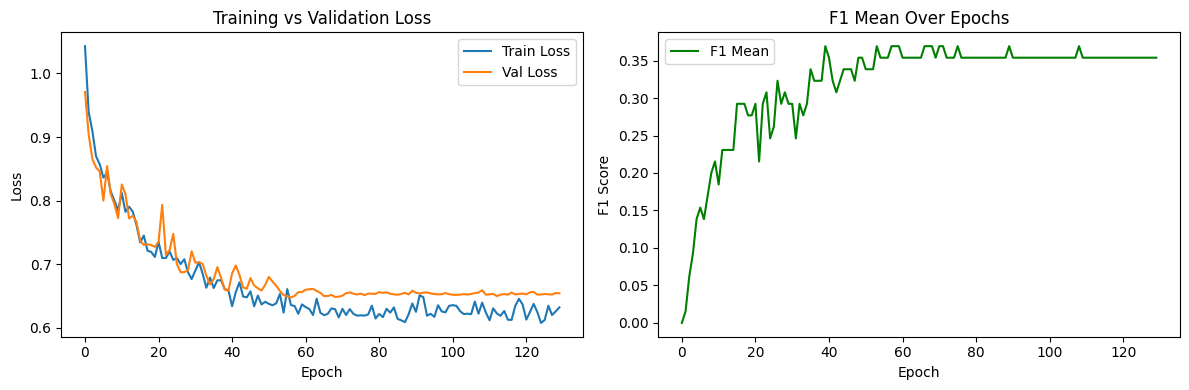

Saved training plot to training_metrics.png


<Figure size 640x480 with 0 Axes>

In [ ]:
# Loss, Optimizer, and Gradient Scaler
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scaler = torch.cuda.amp.GradScaler()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',          # lower val_loss is better
    factor=0.5,          # reduce LR by half
    patience=5,          # wait 5 epochs without improvement
    verbose=True         # log when LR changes
)

num_epochs = 130
accumulation_steps = 4

best_val_loss = float('inf')
best_avg_f1_mean = float('-inf')
best_avg_sq = float('-inf')

train_losses = []
val_losses = []
f1_means = []

for epoch in range(num_epochs):

    train_loss = train_one_epoch(
        model=model,
        train_loader=train_loader,
        criterion=criterion,
        optimizer=optimizer,
        scaler=scaler,
        device=device,
        accumulation_steps=accumulation_steps
    )
    torch.cuda.empty_cache()
    
    avg_val_loss, avg_f1_mean, avg_f1_at_0_5, avg_sq = validate_one_epoch(
        model=model,
        val_loader=val_loader,
        criterion=criterion,
        device=device
    )
    torch.cuda.empty_cache()
    
    # Update scheduler with current validation loss
    scheduler.step(avg_val_loss)

    train_losses.append(train_loss)
    val_losses.append(avg_val_loss)
    f1_means.append(avg_f1_mean)
    
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model_loss.pth")
        saved_loss = True
    else:
        saved_loss = False
        
    if avg_f1_mean > best_avg_f1_mean:
        best_avg_f1_mean = avg_f1_mean
        torch.save(model.state_dict(), "best_model_F1m.pth")
        saved_f1 = True
    else:
        saved_f1 = False
        
    if avg_sq > best_avg_sq:
        best_avg_sq = avg_sq
        torch.save(model.state_dict(), "best_model_SQ.pth")
        saved_sq = True
    else:
        saved_sq = False
        
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] -- Train Loss: {train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, F1_mean: {avg_f1_mean:.4f}")
        print(f"Validation Metrics: F1_mean={avg_f1_mean:.4f}, F1@0.5={avg_f1_at_0_5:.4f}, SQ={avg_sq:.4f}")
            


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(f1_means, label="F1 Mean", color='green')
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("F1 Mean Over Epochs")
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig("training_metrics.png")
print("Saved training plot to training_metrics.png")

<a id="36"></a>  
### 3.6 Load the Best Model & Visualize 


In [ ]:
best_model_path = "best_model_loss.pth"

# Initialize the model with the same architecture
model = ChannelNet_CellViT(
    channel_invariant_config=channel_invariant_config,
    cellvit_config=cellvit_config
).to(device)

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()
print(model)

ChannelNet_CellViT(
  (adapter_pre): ChannelAdapter(
    (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv_out): Conv2d(32, 3, kernel_size=(1, 1), stride=(1, 1))
  )
  (channel_invariant_net): ChannelInvariantNet(
    (conv_0): ChannelInvariantEncoderBlock(
      (maxpool): Identity()
      (conv0): Sequential(
        (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.05, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv1): Sequential(
        (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.05, affine=True, track_running_stats=Tr

3477006323.py (11): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


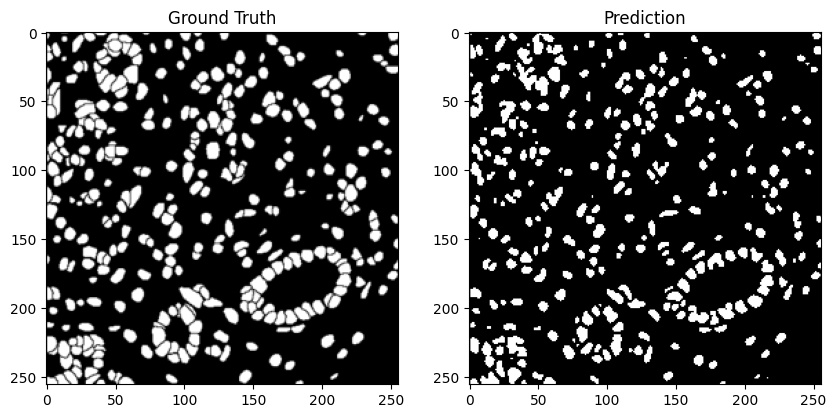

In [ ]:
batch_images, batch_masks = next(iter(val_loader))
batch_images, batch_masks = batch_images.to(device), batch_masks.to(device)

with torch.no_grad():
    outputs = model(batch_images)
    nuclei_binary_map = outputs["nuclei_binary_map"]

pred = torch.argmax(nuclei_binary_map[0], dim=0).cpu().numpy()
true = batch_masks[0].squeeze(0).cpu().numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Ground Truth")
plt.imshow(true, cmap='gray')
plt.subplot(1, 2, 2)
plt.title("Prediction")
plt.imshow(pred, cmap='gray')
plt.show()

<a id="4"></a>  
## 4. Testing & Evaluation

<a id="41"></a>  
### 4.1 Dataset Testing Loader and Preprocessing
This dataset class handles **CODEX** images for inference and evaluation
- Each sample includes:
  - A **cell channel image**
  - A corresponding **binary mask**


#### Preprocessing
- Cell image is loaded as grayscale and **duplicated** into 2 channels → `[2, H, W]`
- Replicated to form a **32-channel input**:  
$$
\text{input} \in \mathbb{R}^{32 \times H \times W}
$$
- Masks are:
- Converted to NumPy, rounded, and cast to `int32`
- Returned as a tensor with shape `[1, H, W]`

In [ ]:
class CODEXDataset(Dataset):
    def __init__(self, root_dir, transform=None, max_channels=32):
        self.root_dir = root_dir
        self.transform = transform
        self.max_channels = max_channels
        self.image_mask_pairs = []

        for sub_dir in os.listdir(self.root_dir):
            sub_path = os.path.join(self.root_dir, sub_dir)
            if os.path.isdir(sub_path):
                # Only check for cell image and mask
                cell_image_path = os.path.join(sub_path, f"{sub_dir}-Crop_Cell_Png.png")
                mask_path = os.path.join(sub_path, f"{sub_dir}-Crop_Cell_Mask_Png.png")

                if not os.path.exists(cell_image_path):
                    print(f"Missing Cell image: {cell_image_path}")
                if not os.path.exists(mask_path):
                    print(f"Missing Mask: {mask_path}")

                if os.path.exists(cell_image_path) and os.path.exists(mask_path):
                    self.image_mask_pairs.append((cell_image_path, mask_path))

        print(f"Total valid samples in CODEX dataset: {len(self.image_mask_pairs)}")

    def __len__(self):
        return len(self.image_mask_pairs)

    def __getitem__(self, idx):
        cell_image_path, mask_path = self.image_mask_pairs[idx]

        cell_image = Image.open(cell_image_path).convert("L")
        mask = Image.open(mask_path).convert("L")  # Assuming grayscale mask

        if self.transform:
            cell_image = self.transform(cell_image).squeeze(0)  # Remove extra channel dimension
            mask = self.transform(mask).squeeze(0)              # [H, W]

        mask = np.array(mask)              
        mask = np.round(mask).astype(np.int32)

        # Instead of stacking and padding with zeros, replicate the single channel.
        # Original: create 2 channels then pad to 32 channels
        merged_image = torch.stack([cell_image, cell_image], dim=0)  # [2, H, W]
        # Compute replication factor to reach 32 channels (2 channels replicated 16 times gives 32)
        replication_factor = self.max_channels // merged_image.size(0)
        replication_dims = (replication_factor,) + (1,) * (merged_image.dim() - 1)
        replicated_image = merged_image.repeat(replication_dims)

        # Convert mask back to tensor and add a channel dimension (so [1, H, W])
        mask = torch.tensor(mask, dtype=torch.int32).unsqueeze(0)

        return replicated_image, mask

In [ ]:
# Define transformations
transform = transforms.Compose([
    PercentileScaling(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),
])

# Initialize the CODEX dataset
codex_dataset = CODEXDataset(
    root_dir="/usr/users/nucleisegmentation/kontaratou_mar/ChannelNet+CellViT/CPDMI_2023/CODEX",
    transform=transform
)

print(f"Total samples in CODEX dataset: {len(codex_dataset)}")


sample_image, sample_mask = codex_dataset[0]
# Check the shapes of the sample image and mask
print(f"Sample Image Shape: {sample_image.shape}")  # Should be [32, 256, 256]
print(f"Sample Mask Shape: {sample_mask.shape}")    # Should be [1, 256, 256]
test_loader = DataLoader(codex_dataset, batch_size=3, shuffle=False, num_workers=4)



Missing Mask: /usr/users/nucleisegmentation/kontaratou_mar/ChannelNet+CellViT/CPDMI_2023/CODEX/CODEX_LN(5900,2600)/CODEX_LN(5900,2600)-Crop_Cell_Mask_Png.png
Total valid samples in CODEX dataset: 9
Total samples in CODEX dataset: 9
Sample Image Shape: torch.Size([32, 256, 256])
Sample Mask Shape: torch.Size([1, 256, 256])


In [ ]:
model = ChannelNet_CellViT(
    channel_invariant_config=channel_invariant_config,
    cellvit_config=cellvit_config,
).to(device)

# Load the trained weights
model.load_state_dict(torch.load("best_model_loss.pth", map_location=device))
model.eval()  
print("Model loaded successfully!")

Model loaded successfully!


2233323350.py (10): You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



<a id="42"></a>  
### 4.2 Model Evaluation on Test Set

WWe evaluate the trained model on unseen data using both **pixel-wise** and **instance-aware** metrics:

- **Thresholding & Post-processing**:
  - Foreground probability threshold: `0.3`
  - Small object removal and hole filling to clean predictions

- **Instance Metrics** (via StarDist matching):
  - **PQ** (Panoptic Quality)
  - **SQ** (Segmentation Quality)
  - **F₀.₅₁ Score**
  - **Fµ₁ Score**: averaged F1 over IoU thresholds from 0.5–0.9

- **Pixel Metrics**:
  - F1 Score, Precision, Recall, mAP, Pixel Accuracy

We also visualize `num_samples=5` predictions alongside ground truth masks for qualitative comparison

Evaluating:   0%|          | 0/3 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 3/3 [00:01<00:00,  2.68it/s]


 Test Set Evaluation Metrics (After Post-processing):
Panoptic Quality (PQ): 0.0363
Segmentation Quality (SQ): 0.5897
F₀.₅₁ Score: 0.0342
Fµ₁ Score: 0.0162
F1 Score: 0.7147
Precision: 0.8179
Recall: 0.6368
Mean Average Precision (mAP): 0.7712
Pixel Accuracy: 0.6548


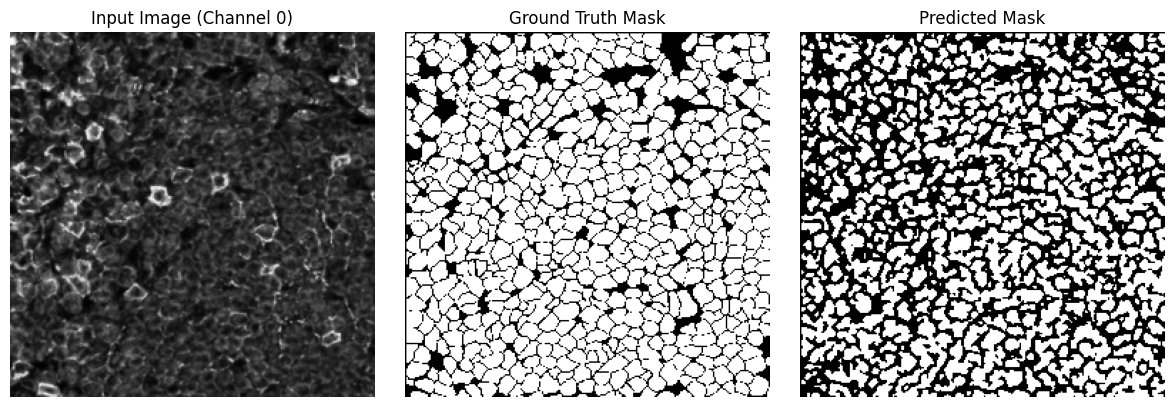

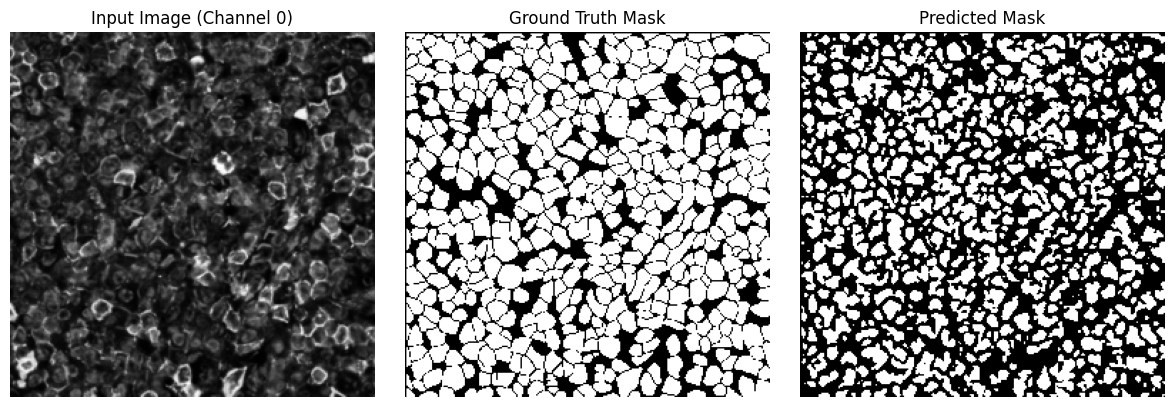

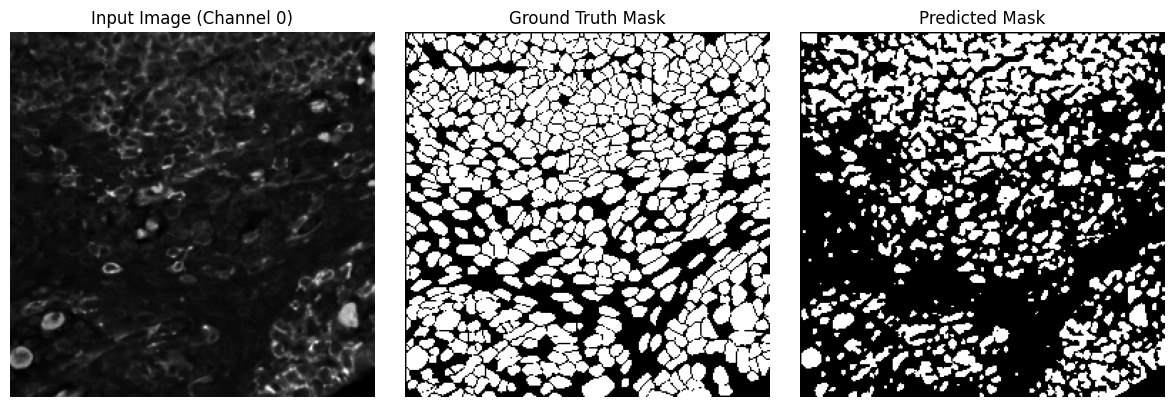

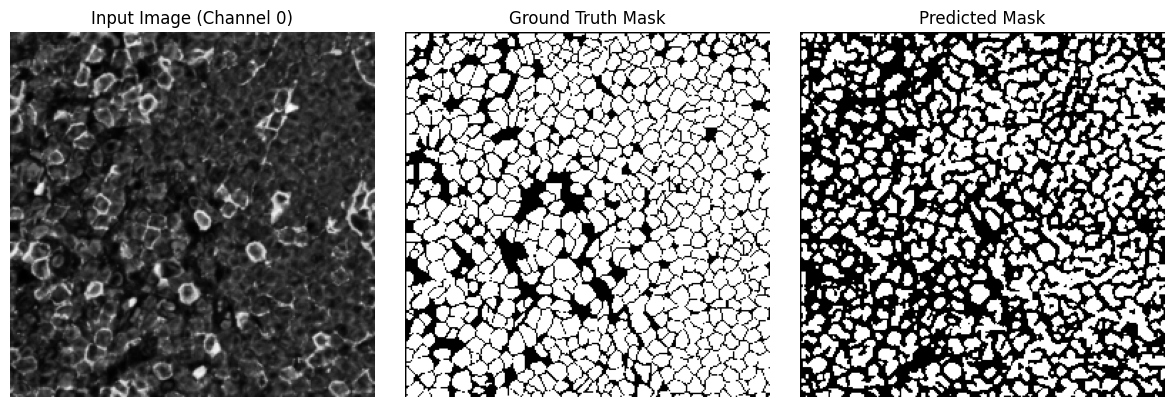

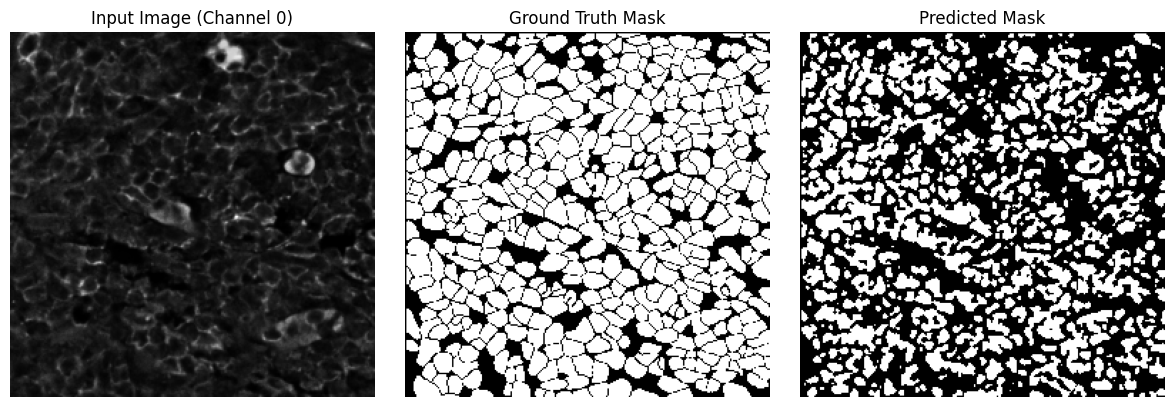

In [ ]:
def evaluate_model_on_test(model, test_loader, device, use_instance_masks=True, visualize=True):
    model.eval()
    
    pq_scores, f1s, precisions, recalls, aps, pixel_accuracies, sq_scores = [], [], [], [], [], [], []
    f051_scores_nuclei = []
    fu1_scores_nuclei = []

    iou_thresholds = np.arange(0.5, 1.0, 0.1)  # 0.5 to 0.9 inclusive

    with torch.no_grad():
        for batch_images, batch_masks in tqdm(test_loader, desc="Evaluating"):
            batch_images = batch_images.to(device)
            batch_masks = batch_masks.to(device)

            outputs = model(batch_images)
            logits = outputs["nuclei_binary_map"]
            probs = softmax(logits, dim=1)

            probs_fg = probs[:, 1, :, :]
            preds = (probs_fg > 0.3).float()

            post_processed_preds = []
            for i in range(preds.shape[0]):
                pred_np = preds[i].cpu().numpy().astype(np.uint8)
                pred_np = remove_small_objects(pred_np.astype(bool), min_size=32)
                pred_np = remove_small_holes(pred_np, area_threshold=32)
                post_processed_preds.append(pred_np.astype(np.uint8))

            preds = np.stack(post_processed_preds)

            for i in range(batch_images.size(0)):
                pred_np = preds[i]
                true_np = batch_masks[i].squeeze(0).cpu().numpy().astype(np.uint8)

                if use_instance_masks:
                    pred_inst = label(pred_np)
                    true_inst = label(true_np)

                    # Panoptic Quality (PQ) & Segmentation Quality (SQ)
                    match = matching.matching(true_inst, pred_inst, thresh=0.5)
                    tp, fp, fn = match.tp, match.fp, match.fn
                    pq = tp / (tp + 0.5 * (fp + fn) + 1e-6)
                    pq_scores.append(pq)
                    sq_scores.append(match.mean_matched_score)

                    # F₀.₅₁ Score
                    match_051 = matching.matching(true_inst, pred_inst, thresh=0.51)
                    f051 = match_051.tp / (match_051.tp + 0.5 * (match_051.fp + match_051.fn) + 1e-6)
                    f051_scores_nuclei.append(f051)

                    # Fµ₁ Score
                    f1s_over_thresh = []
                    for thresh in iou_thresholds:
                        mt = matching.matching(true_inst, pred_inst, thresh=thresh)
                        f1_at_t = mt.tp / (mt.tp + 0.5 * (mt.fp + mt.fn) + 1e-6)
                        f1s_over_thresh.append(f1_at_t)
                    fu1_scores_nuclei.append(np.mean(f1s_over_thresh))
                else:
                    pq_scores.append(0)
                    sq_scores.append(0)
                    f051_scores_nuclei.append(0)
                    fu1_scores_nuclei.append(0)

                # Pixel-wise metrics
                pred_flat = pred_np.flatten()
                true_flat = true_np.flatten()

                f1s.append(f1_score(true_flat, pred_flat, zero_division=0))
                precisions.append(precision_score(true_flat, pred_flat, zero_division=0))
                recalls.append(recall_score(true_flat, pred_flat, zero_division=0))
                aps.append(average_precision_score(true_flat, pred_flat))
                pixel_accuracies.append(np.mean(pred_flat == true_flat))

    metrics = {
        "Panoptic Quality (PQ)": np.mean(pq_scores),
        "Segmentation Quality (SQ)": np.mean(sq_scores),
        "F₀.₅₁ Score": np.mean(f051_scores_nuclei),
        "Fµ₁ Score": np.mean(fu1_scores_nuclei),
        "F1 Score": np.mean(f1s),
        "Precision": np.mean(precisions),
        "Recall": np.mean(recalls),
        "Mean Average Precision (mAP)": np.mean(aps),
        "Pixel Accuracy": np.mean(pixel_accuracies),
    }

    print("\n Test Set Evaluation Metrics (After Post-processing):")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

    return metrics


def visualize_predictions(model, test_loader, device, num_samples=5):
    model.eval()
    shown = 0

    with torch.no_grad():
        for batch_images, batch_masks in test_loader:
            batch_images = batch_images.to(device)
            batch_masks = batch_masks.to(device)

            outputs = model(batch_images)
            probs = softmax(outputs["nuclei_binary_map"], dim=1)
            preds = torch.argmax(probs, dim=1)

            for i in range(batch_images.size(0)):
                if shown >= num_samples:
                    return
                image_np = batch_images[i, 0].cpu().numpy()
                mask_np = batch_masks[i].squeeze(0).cpu().numpy()
                pred_np = preds[i].cpu().numpy()

                plt.figure(figsize=(12, 4))

                plt.subplot(1, 3, 1)
                plt.imshow(image_np, cmap='gray')
                plt.title("Input Image (Channel 0)")
                plt.axis("off")

                plt.subplot(1, 3, 2)
                plt.imshow(mask_np, cmap='gray')
                plt.title("Ground Truth Mask")
                plt.axis("off")

                plt.subplot(1, 3, 3)
                plt.imshow(pred_np, cmap='gray')
                plt.title("Predicted Mask")
                plt.axis("off")

                plt.tight_layout()
                plt.show()
                shown += 1


metrics = evaluate_model_on_test(model, test_loader, device, use_instance_masks=True)
visualize_predictions(model, test_loader, device, num_samples=5)